In [62]:
import torch
import numpy as np
import nibabel as ni
import os, shutil
import time
import random
import pandas as pd 

def split_train_test(dir, ratio_test=0.15):
    if not os.path.exists(os.path.join(dir, "train")): os.mkdir(os.path.join(dir, "train"))
    if not os.path.exists(os.path.join(dir, "test")): os.mkdir(os.path.join(dir, "test"))
    
    images_list = [i for i in os.listdir(dir) if i.endswith(".nii")]

    random.shuffle(images_list)
    threshold = int(len(images_list)*ratio_test)
    train_list = images_list[:-threshold]
    test_list = images_list[-threshold:]

    for i in train_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "train", i))
    for i in test_list:
        shutil.move(os.path.join(dir, i), os.path.join(dir, "test", i))

def save_data_to_csv(dir, z):
    pd.DataFrame(z).to_csv(dir, header=None, index=False)

def load_mri_images(path, batch_size):
    filenames = [i for i in os.listdir(path) if i.endswith(".nii.gz")] #and i.startswith("norm_023_S_0030")
    random.shuffle(filenames)
    n = 0
    while n < len(filenames):
        batch_image = []
        for i in range(n, n + batch_size):
            if i >= len(filenames):
                ##n = i
                break
            #print(filenames[i])
            image = ni.load(os.path.join(path, filenames[i]))
            # print("Original image shape:", image.shape, "vs (80,96,80)")

            image = np.array(image.dataobj)
            image = np.pad(image, ((1,0), (1,0), (1, 0)), "constant", constant_values=0)
            image = torch.Tensor(image)

            image = torch.reshape(image, (1, 1) + image.shape)  # Keeps original shape if unknown
            # image = torch.reshape(image, (1,1, 80, 96, 80))
            #image = (image - image.min()) / (image.max() - image.min())
            image = image / 255.
            batch_image.append(image)
        n += batch_size
        batch_image = torch.cat(batch_image, axis=0)
        yield batch_image

#################### TEST #################  
path = "C:/Users/kiran/Documents/_UIS/sem6/BACH/Data/_testfew/" 
start = time.time()
loaded = load_mri_images(path, 2)
for i in loaded:
    print(time.time()-start)
    start = time.time()
    print(i.shape)

Original image shape: (208, 240, 256) vs (80,96,80)
Original image shape: (208, 240, 256) vs (80,96,80)
0.4297037124633789
torch.Size([2, 1, 209, 241, 257])


Original image shape: (208, 240, 256) vs (80,96,80)
Converted image shape: (208, 240, 256)
Cropped image shape: (208, 144, 154)


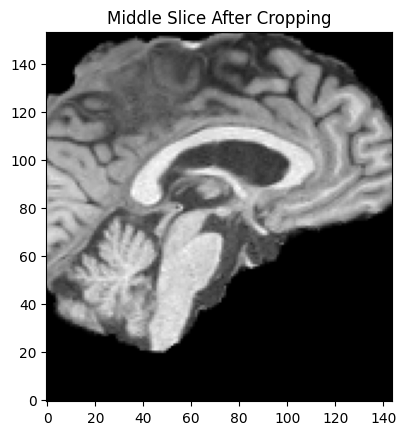

In [63]:
import nibabel as ni
import numpy as np
import matplotlib.pyplot as plt

path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\Data\_testfew\35_sub-ADNI003S4872_ses-M120_T1w_brain_brain_restore_norm.nii.gz"

# Load MRI image
image = ni.load(path)
print("Original image shape:", image.shape, "vs (80,96,80)")

# Convert to NumPy array
image = np.array(image.get_fdata())  # Use .get_fdata() to retrieve actual image data
print("Converted image shape:", image.shape)  # Should be (208, 240, 256)

# Crop to a region (e.g., center 80x96x80 from 208x240x256)
dx = 0.2
s1 = image.shape[0]
s2 = image.shape[1]
s3 = image.shape[2]
dy = 0.2

image = image[:, 
              round(s2*dx):round(s2*(1-dx)), 
              round(s3*dy):round(s3*(1-dy))]  # Adjust based on observation
print("Cropped image shape:", image.shape)  # Should be (80, 96, 80)

# Display a middle slice from the first axis
plt.imshow(image[image.shape[0] // 2, :, :].T, cmap='gray', origin="lower")
plt.title("Middle Slice After Cropping")
plt.show()
